In [7]:
import serial
import serial.tools.list_ports
import pyvisa
import matplotlib.pyplot as plt
import TeledyneLeCroyPy
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.colors as mcolors

rm = pyvisa.ResourceManager()
print(rm.list_resources())

serial.tools.list_ports.comports(include_links=True)

# to deal with already initialised oscilloscope
lecroy = None

('TCPIP0::169.254.1.214::inst0::INSTR', 'GPIB1::9::INSTR', 'GPIB1::23::INSTR')


In [8]:
ps = rm.open_resource('GPIB1::23::INSTR')
print(ps.query('*IDN?'))

ps.write(':OUTP:LOW FLO')
ps.write(':OUTP:OFF:AUTO ON')
ps.write(':OUTP:PROT ON')
ps.write(':OUTP:RES:MODE FIX')
ps.write(':OUTP:RES:SHUN DEF')
ps.write(':SOUR:FUNC:MODE CURR')
ps.write(':SOUR:CURR:MODE FIX')
ps.write(':SOUR:CURR:LEV -2e-6')
ps.write(':DISP:ENAB OFF')
ps.write(':DISP:TEXT:DATA "pFREYA16"')
ps.write(':DISP:TEXT:STAT ON')
ps.write(':OUTP:STAT ON')

print(f'''
Low terminal: {ps.query(':OUTP:LOW?')[:-1]}
Auto output off: {ps.query(':OUTP:OFF:AUTO?')[:-1]}
Protection: {ps.query(':OUTP:PROT?')[:-1]}
Resistance mode: {ps.query(':OUTP:RES:MODE?')[:-1]}
Shunt resistance : {ps.query(':OUTP:RES:SHUN?')[:-1]}
Output current mode: {ps.query(':SOUR:CURR:MODE?')[:-1]}
Output current level: {ps.query(':SOUR:CURR:LEV?')[:-1]}
Output voltage range: {ps.query(':SOUR:VOLT:RANG?')[:-1]}
Output status: {ps.query(':OUTP:STAT?')[:-1]}
	''')

pg = rm.open_resource('GPIB1::9::INSTR')
print(pg.query('*IDN?'))

csa_reset_n_pattern = ''.join([f'{i}' for i in [1]*20 + [0]*980])
csa_reset_n_length = str(len(csa_reset_n_pattern))
csa_reset_n_length_length = str(len(str(len(csa_reset_n_pattern))))

pg.write('*RST')
pg.write(f':TRIG:COUN {csa_reset_n_length}')
pg.write(f':TRIG:SOUR INT')
pg.write(f':PULS:PER 15NS')
pg.write(f':PULS:DCYC1 50PCT')
pg.write(f':PULS:DCYC2 50PCT')
pg.write(f':PULS:TRAN1 3NS')
pg.write(f':PULS:TRAN2 3NS')
pg.write(':DIG:STIM:PATTERN:STAT ON')
pg.write(f':DIG:STIM:PATTERN:DATA1 #{csa_reset_n_length_length}{csa_reset_n_length}{csa_reset_n_pattern}')
pg.write(f':DIG:STIM:PATTERN:PRES2 2,{csa_reset_n_length}')
pg.write(f':DIG:STIM:PATTERN:DATA3 #{csa_reset_n_length_length}{csa_reset_n_length}{csa_reset_n_pattern}')
pg.write(f':DIG:STIM:SIGN1:FORM NRZ')
pg.write(f':DIG:STIM:SIGN2:FORM NRZ')
pg.write(':OUTP1:IMP:INT 50OHM')
pg.write(':OUTP1:IMP:EXT 100OHM')
pg.write(':OUTP2:IMP:INT 50OHM')
pg.write(':OUTP2:IMP:EXT 100OHM')
pg.write(':VOLT1:LEV:HIGH 1.2V')
pg.write(':VOLT1:LEV:LOW 0V')
pg.write(':VOLT2:LEV:HIGH 1.2V')
pg.write(':VOLT2:LEV:LOW 0V')
pg.write(':OUTP1 ON')
pg.write(':OUTP2 ON')

print(f'''
Number of pattern positions: {pg.query(':TRIG:COUN?')[:-1]}
Source of the trigger: {pg.query(':TRIG:SOUR?')[:-1]}
Period of the pulse: {pg.query(':PULS:PER?')[:-1]}
Duty cycle of the pulse: {pg.query(':PULS:DCYC1?')[:-1]}
Rise time of the pulse: {pg.query(':PULS:TRAN1?')[:-1]}
Type of pulse: PATTERN
CH1 data: 20 1's, 980 0's
CH2 data: as the clock
STRB data: 20 1's, 980 0's
Type of the pulse: {pg.query(':DIG:STIM:SIGN1:FORM?')[:-1]}
Internal impedance (source): {pg.query(':OUTP1:IMP:INT?')[:-1]}
External impedance (termination): {pg.query(':OUTP1:IMP:EXT?')[:-1]}
High level: {pg.query(':VOLT1:LEV:HIGH?')[:-1]}
Low level: {pg.query(':VOLT1:LEV:LOW?')[:-1]}
Output 1 status: {pg.query(':OUTP1?')[:-1]}
Output 2 status: {pg.query(':OUTP2?')[:-1]}
	''')

if lecroy is None:
	lecroy = TeledyneLeCroyPy.LeCroyWaveRunner('TCPIP0::169.254.1.214::inst0::INSTR')
print(lecroy.idn)

# not setting the whole configuration for the time being, just doing the measurements
#print(lecroy.query('TEMPLATE?'))

Agilent Technologies,B2961A,MY52350174,1.0.1236.9609


Low terminal: FLO
Auto output off: 1
Protection: 1
Resistance mode: FIX
Shunt resistance : +2.00000000E+009
Output current mode: FIX
Output current level: -2.00000000E-006
Output voltage range: +2.00000000E+000
Output status: 1
	
HEWLETT-PACKARD,HP81104A,DE38700607,REV 01.10.00


Number of pattern positions: +1000
Source of the trigger: IMM
Period of the pulse: +1.5000E-08
Duty cycle of the pulse: +5.0000E+01
Rise time of the pulse: +3.0000E-09
Type of pulse: PATTERN
CH1 data: 20 1's, 980 0's
CH2 data: as the clock
STRB data: 20 1's, 980 0's
Type of the pulse: NRZ
Internal impedance (source): +5.0000E+01
External impedance (termination): +1.0000E+02
High level: +1.2000E+00
Low level: +0.0000E+00
Output 1 status: 1
Output 2 status: 1
	
LECROY,WP804HD,LCRY4608N02718,10.0.0


In [25]:
# for each step set a current level, take some data
# next plot everything and calculate statistics

# The integral in the range is given by Iinj_int and should be converted to PH_EQ by means
#  of the following eq: PH_EQ = Iinj_int*2.28e16 keV/C / 9 keV = Iinj_int * 2.53e15

# The general integral for a trap(t-t_i,t_r,t_r,T), where t_i is the arrival time, t_r is the rise time and its the same as the fall time, T is the period
#  of pulse + rest (50% duty cycle) is equal to T/2-t_r
# Therefore Iinj_int = (T/2-t_r)*Iin = Qin

# With 0 A there is actually a negative injection (yay!)
# 	Evaluating the offset (@ 9keV, sim) at 0 is 6.16 eq ph or 2.43fA. With a current of 0.02 uA it goes away. In real life it goes with 0.06 uA.
# With max it is not perfect
# 	doing the same as above, one gets a correction factor of around 105.8fA/103.2fA
T = 30e-9 # s
t_r = 3e-9 # s
N_pulses = 10 # adimensional
conv_kev_c = 3.65/1000 * 1/1.602e-19 # Energy in silicon for e-/h * no of electrons per coulomb [keV/e-] * [e-/C]
config_bits = [0,1,0,0,0,1,1]
csa_bits = config_bits[0:2]
shap_bits = config_bits[3:5]
channel = 2 # 1 csa 2 shap
match csa_bits:
	case [0,1]:
		photon_energy = 9 # keV
		offset_charge = 8.5e-15 # C *tentative
		min_current = .07e-6 # A
		max_current = 1.8e-6 # A
		corr_fact = 1 #105.8/103.2
	case [0,0]:
		photon_energy = 25 # keV
		offset_charge = 8.5e-15 # C *tentative
		min_current = .07e-6 # A
		max_current = 4.3e-6 #3.5e-6 # A
		corr_fact = 1 #105.8/103.2
	case [1,0]:
		photon_energy = 18 # keV
		offset_charge = 8.5e-15 # C *tentative
		min_current = .07e-6 # A
		max_current = 3.5e-6 # A
		corr_fact = 1 #105.8/103.2
	case [1,1]:
		photon_energy = 5 # keV
		offset_charge = 0 #8.5e-15 # C *tentative
		min_current = .07e-6 # A
		max_current = 1e-6 # A
		corr_fact = 1 #105.8/103.2
match shap_bits:
	case [1,0]: peaking_time = 432 # ns
	case [0,0]: peaking_time = 234 # ns
	case [0,1]: peaking_time = 332 # ns
	case [1,1]: peaking_time = 535 # ns

current_lev = -1 * np.linspace(min_current,max_current,8)
iinj_int = current_lev * (T/2-t_r) * N_pulses + offset_charge
eq_ph = -1 * iinj_int * corr_fact * conv_kev_c / photon_energy
config_bits_str = ''.join([str(x) for x in config_bits])
print(f'current range: {current_lev[0]}, {current_lev[-1]}')
print(f'Injection integral (min and max): {iinj_int[0]}, {iinj_int[-1]}')
print(f'photon energy @ {photon_energy} keV: {eq_ph[0]}, {eq_ph[-1]}')
print(f'Config bits: {config_bits_str}')

current range: -7e-08, -1.8e-06
Injection integral (min and max): 1.0000000000000084e-16, -2.0749999999999995e-13
photon energy @ 9 keV: -0.2531557775003489, 525.2982383132195
Config bits: 0101011


In [ ]:
#print(lecroy.query('C1:CRVA? HREL').split(',')[2])
ps.write(':SOUR:CURR:LEV 0')

18

In [26]:
channel = 2
channel_name = 'csa' if channel == 1 else 'shap'
gain = 5.6/2 if channel == 1 else 5.6/2
df = pd.DataFrame()
for i, cl in enumerate(current_lev):
	# set current level
	ps.write(f':SOUR:CURR:LEV {cl}')
	time.sleep(10)
	# N sample to average and extract std from
	data = pd.DataFrame.from_dict(lecroy.get_waveform(n_channel=channel)['waveforms'][0])
	data['Amplitude (V)'] = data['Amplitude (V)']/gain
	data.insert(0, 'Current level step', i)
	data.insert(1, 'Current level (A)', cl)
	df = pd.concat((df, data))

datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
df.to_csv(f'G:/My Drive/PHD/FALCON/measures/transient/{channel_name}/{channel_name}_{config_bits_str}_nominal_{datetime_str}.tsv', '\t')

In [27]:
df = pd.read_csv('G:/My Drive/PHD/FALCON/measures/transient/csa/csa_0101011_nominal_030424_153732.tsv',sep='\t')
datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
channel_name = 'csa'

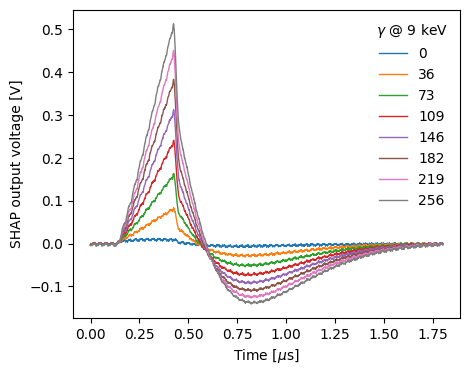

In [27]:
t_s = 0e-9 if channel == 1 else -100e-9
t_e = .7e-6 if channel == 1 else 1.8e-6
sub_df = df[df['Time (s)'].between(t_s, t_e)]

colours = list(mcolors.TABLEAU_COLORS.keys())
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(5)
for i, cl in enumerate(current_lev):
	ax.plot(
		sub_df[sub_df['Current level step'] == i]['Time (s)']*10**6,
		sub_df[sub_df['Current level step'] == i]['Amplitude (V)'],
		'-', linewidth=1, color=colours[i])
ax.set_xlabel('Time [$\\mu$s]')
ax.set_ylabel(f'{channel_name.upper()} output voltage [V]')
ax.legend(np.linspace(0,256,8).astype(int),
		  title=f"$\\gamma$ @ {photon_energy} keV",
		  frameon=False)
plt.savefig(f'G:/My Drive/PHD/FALCON/measures/transient/{channel_name}/{channel_name}_{config_bits_str}_nominal_{datetime_str}.pdf',dpi=300)